# Lab 3: Building A Search Agent

In this lab, we'll use the Azure AI Agent Service to create an agent that is able to retrieve information from documents stored in Azure AI Search, a vector database. The documents that we'll be searching are health insurance policies.

### Part 1: Create the Azure AI Search Index

We'll start the lab by creating an Azure AI Search index, which will contain vectorized representations of our health insurance plan documents. The steps shown below to create the AI Search index are from the official Microsoft [documentation](https://learn.microsoft.com/en-us/azure/search/search-get-started-portal-import-vectors?tabs=sample-data-storage%2Cmodel-aoai%2Cconnect-data-storage)

#### Step 1
To begin, download the [documents](https://github.com/Azure-Samples/azure-search-sample-data/tree/main/health-plan) that we'll store in the Azure AI Search index.

#### Step 2
Next, we'll upload the health plan documents to Azure Blob Storage, which Azure AI search connects to.
1. Navigate to your Storage Account. 
2. Expand "Data Storage" in the side menu and click on "Containers". 
3. Create a new container named "healthplan"

    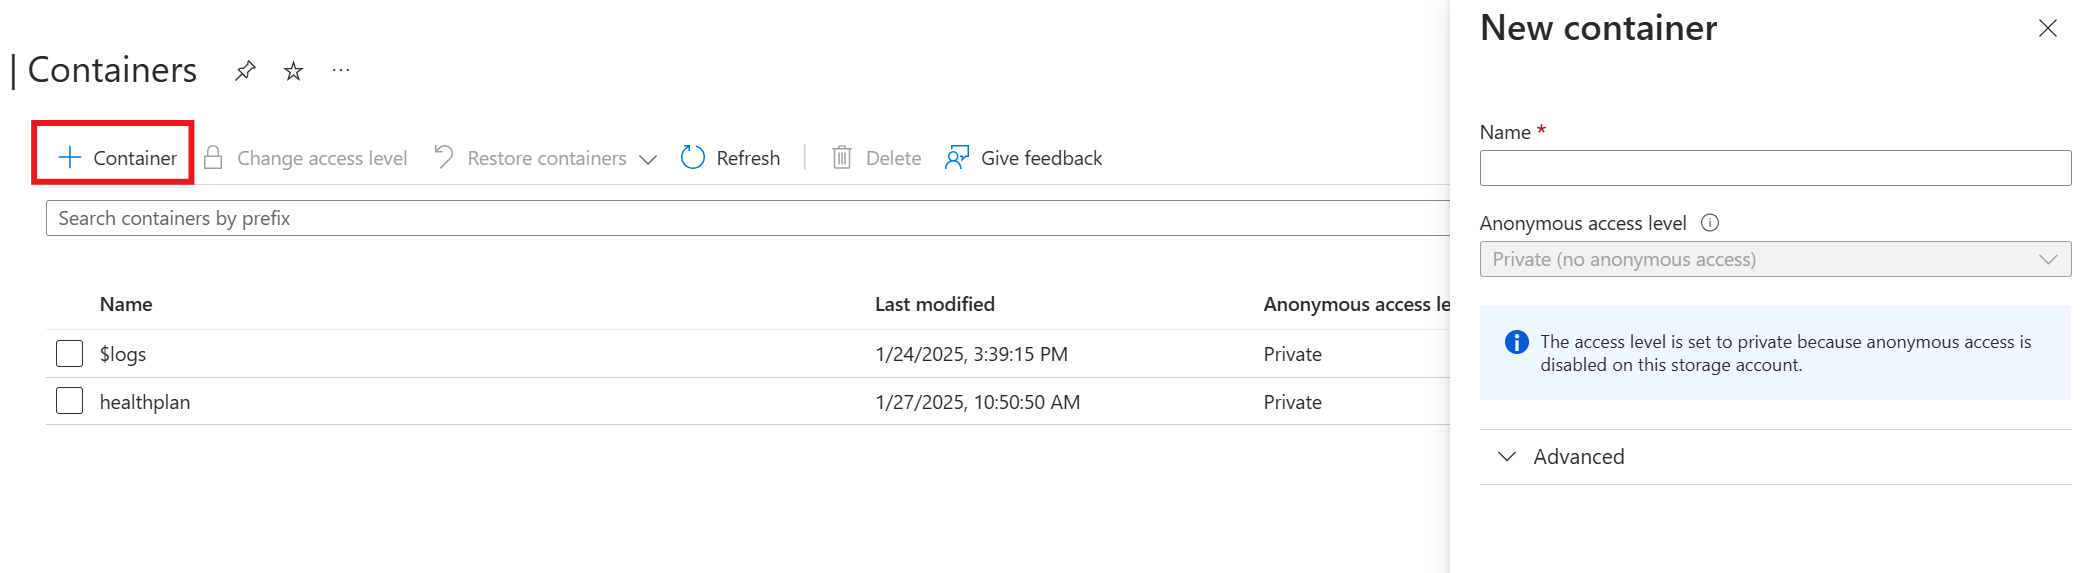
4. Click into the new container and upload the documents you downloaded.

    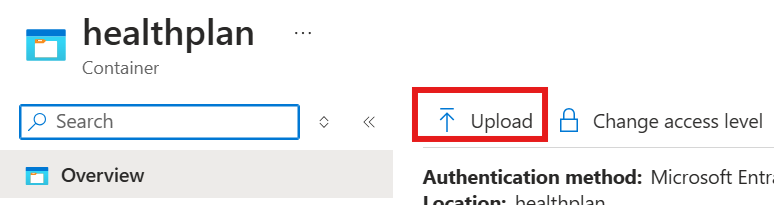

#### Step 3
We need an embedding model in order to convert our documents into vectors that will be stored in Azure AI Search. We'll deploy an `text-embedding-3-large` embedding model in the Azure OpenAI Service.
1. Navigate to your Azure OpenAI Service resource.
2. Under "Shared resources" in the side menu, click on "Deployments". 
3. Click "Deploy base model".

    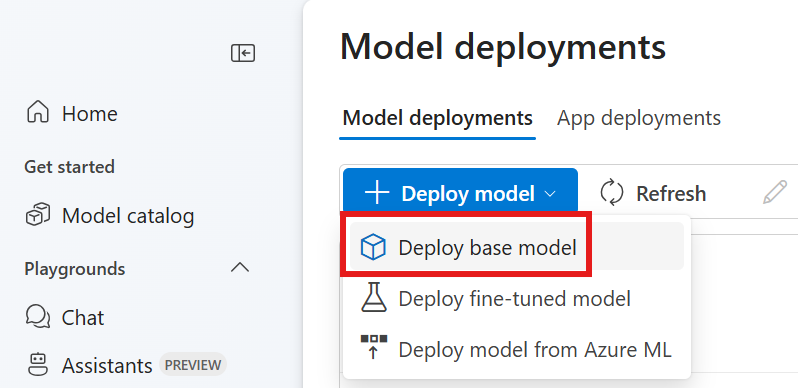
4. Find the `text-embedding-3-large` model, select it, and confirm. 
    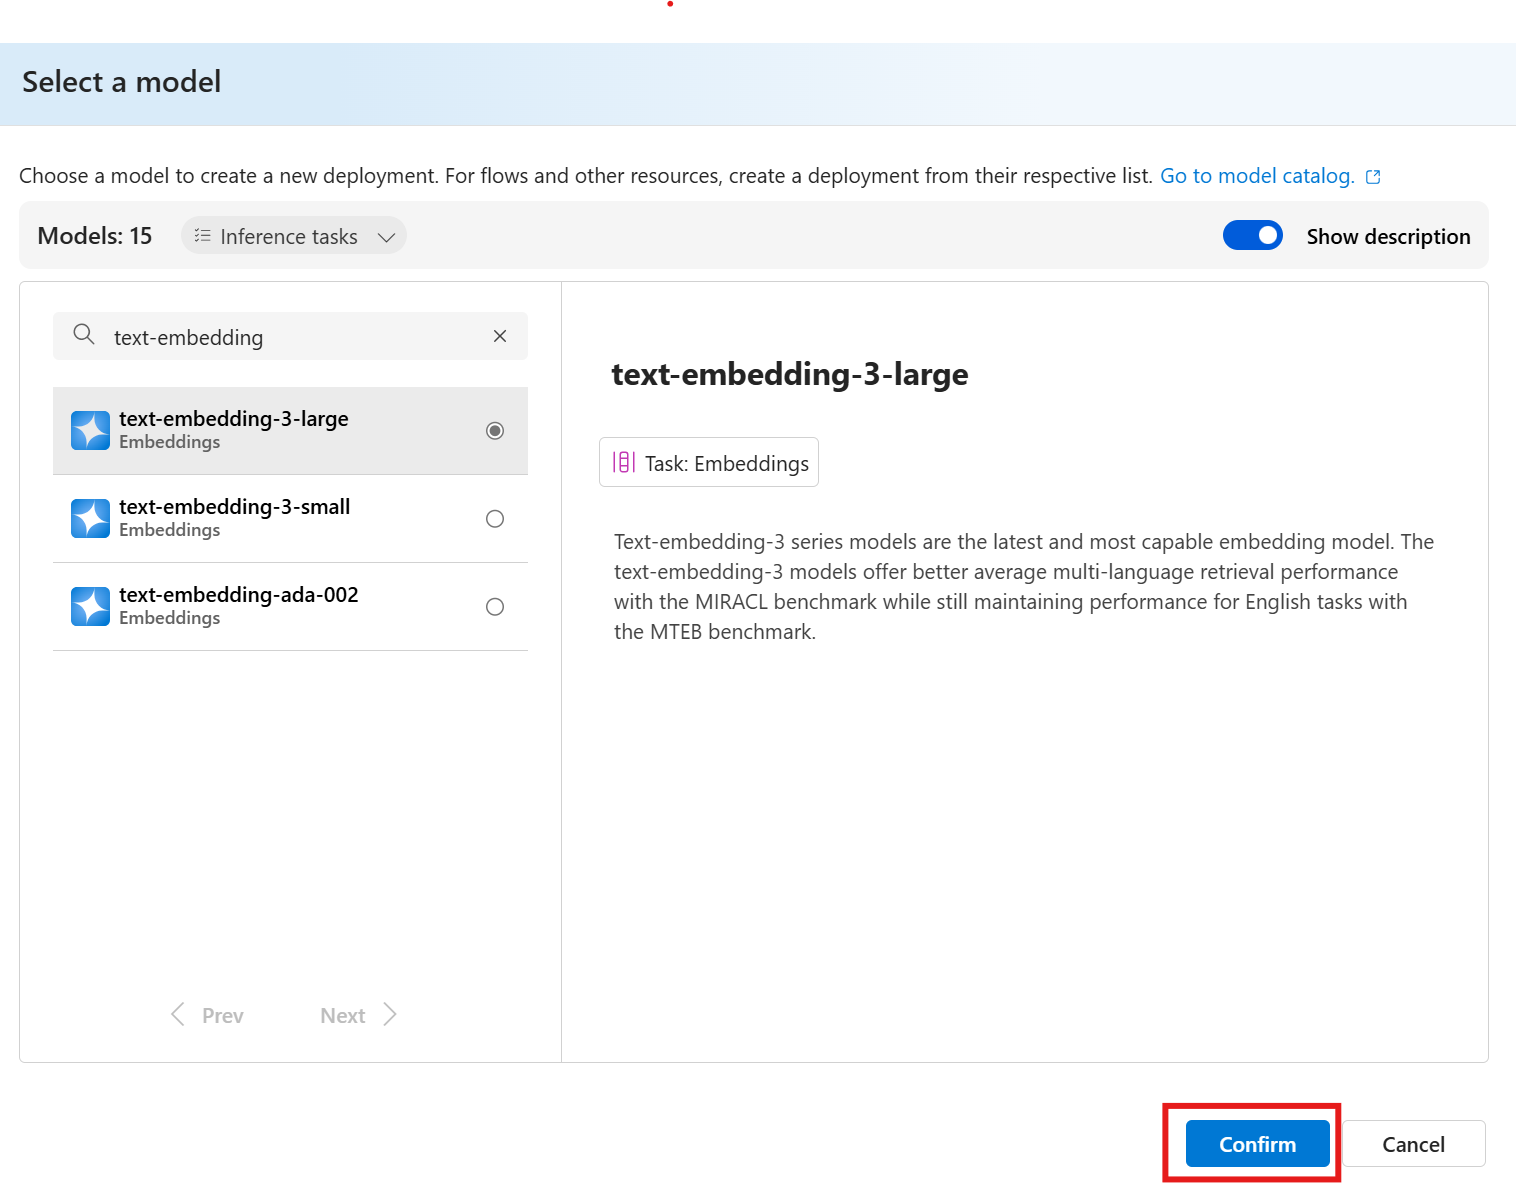
5. Lastly, deploy the model.
    
    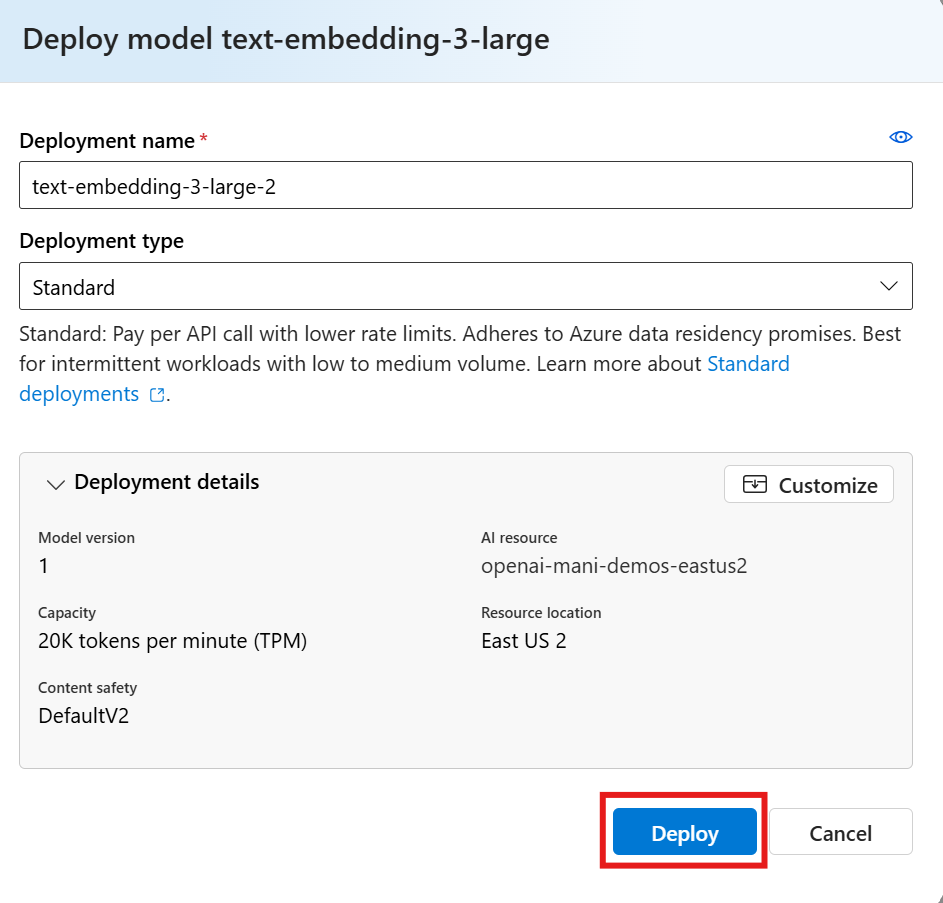

#### Step 4
Now we're ready to vectorize our documents.
1. Go to your Azure AI Search Service and on the **Overview page**, select **Import and vectorize data**.
2. On **Set up your data connection**, select **Azure Blob Storage**.
3. Specify your subscription, storage account, and the container that contains your healthplans. 
4. Make sure **Authenticate using managed idenity is checked** and the **Managed identity type** is set to **System-assigned**.

    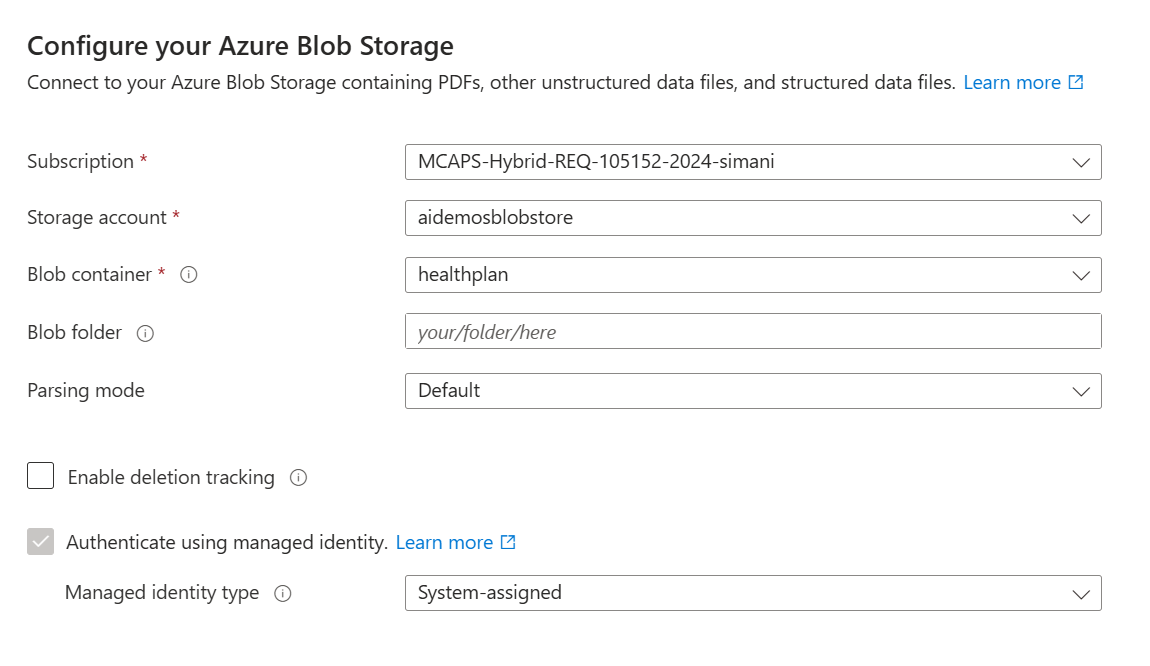
5. On the **Vectorize your text** page, select **Azure OpenAI** for **Kind**, select your subscription, and select the name of your Azure OpenAI Service.
6. For the **Model deployment** select `text-embedding-3-large`. 
7. The **Authentication type** should be set to **System-assigned identity**. 
8. Select the box next to the acknowledgement.

    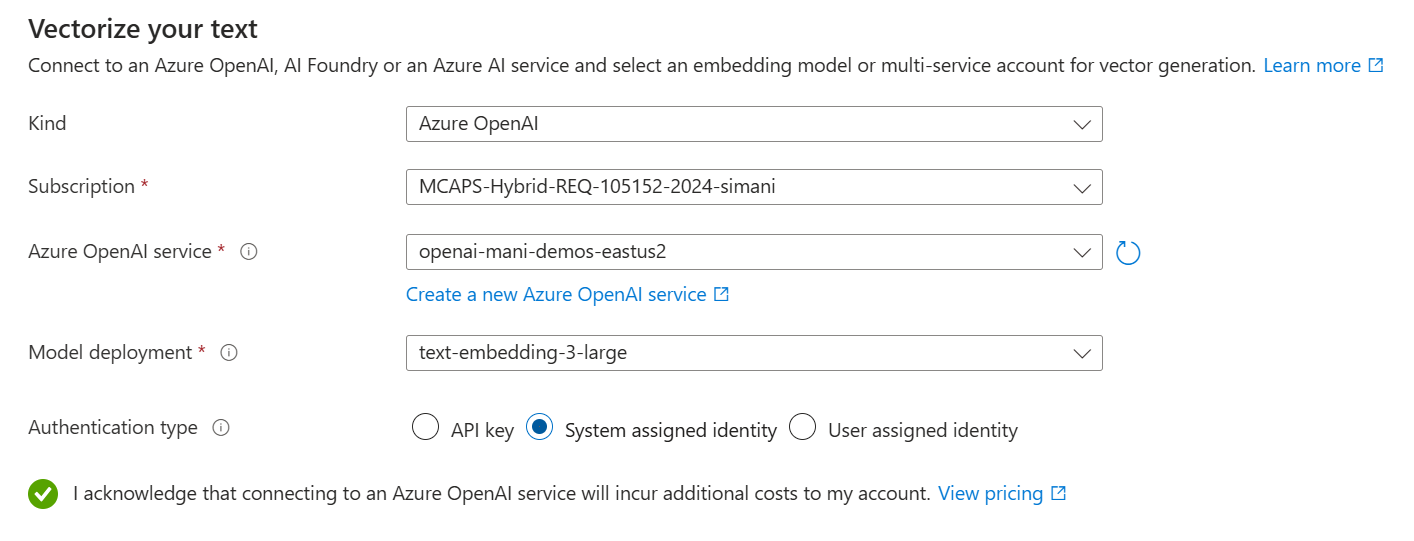
9. You can hit **Next** for the next two pages. When you get to the **Review and create** page, set **Objects name prefix** to **healthplan-index**. 
10. Click **Create**. This will start the document indexing process which will vectorize your documents and create an index.

    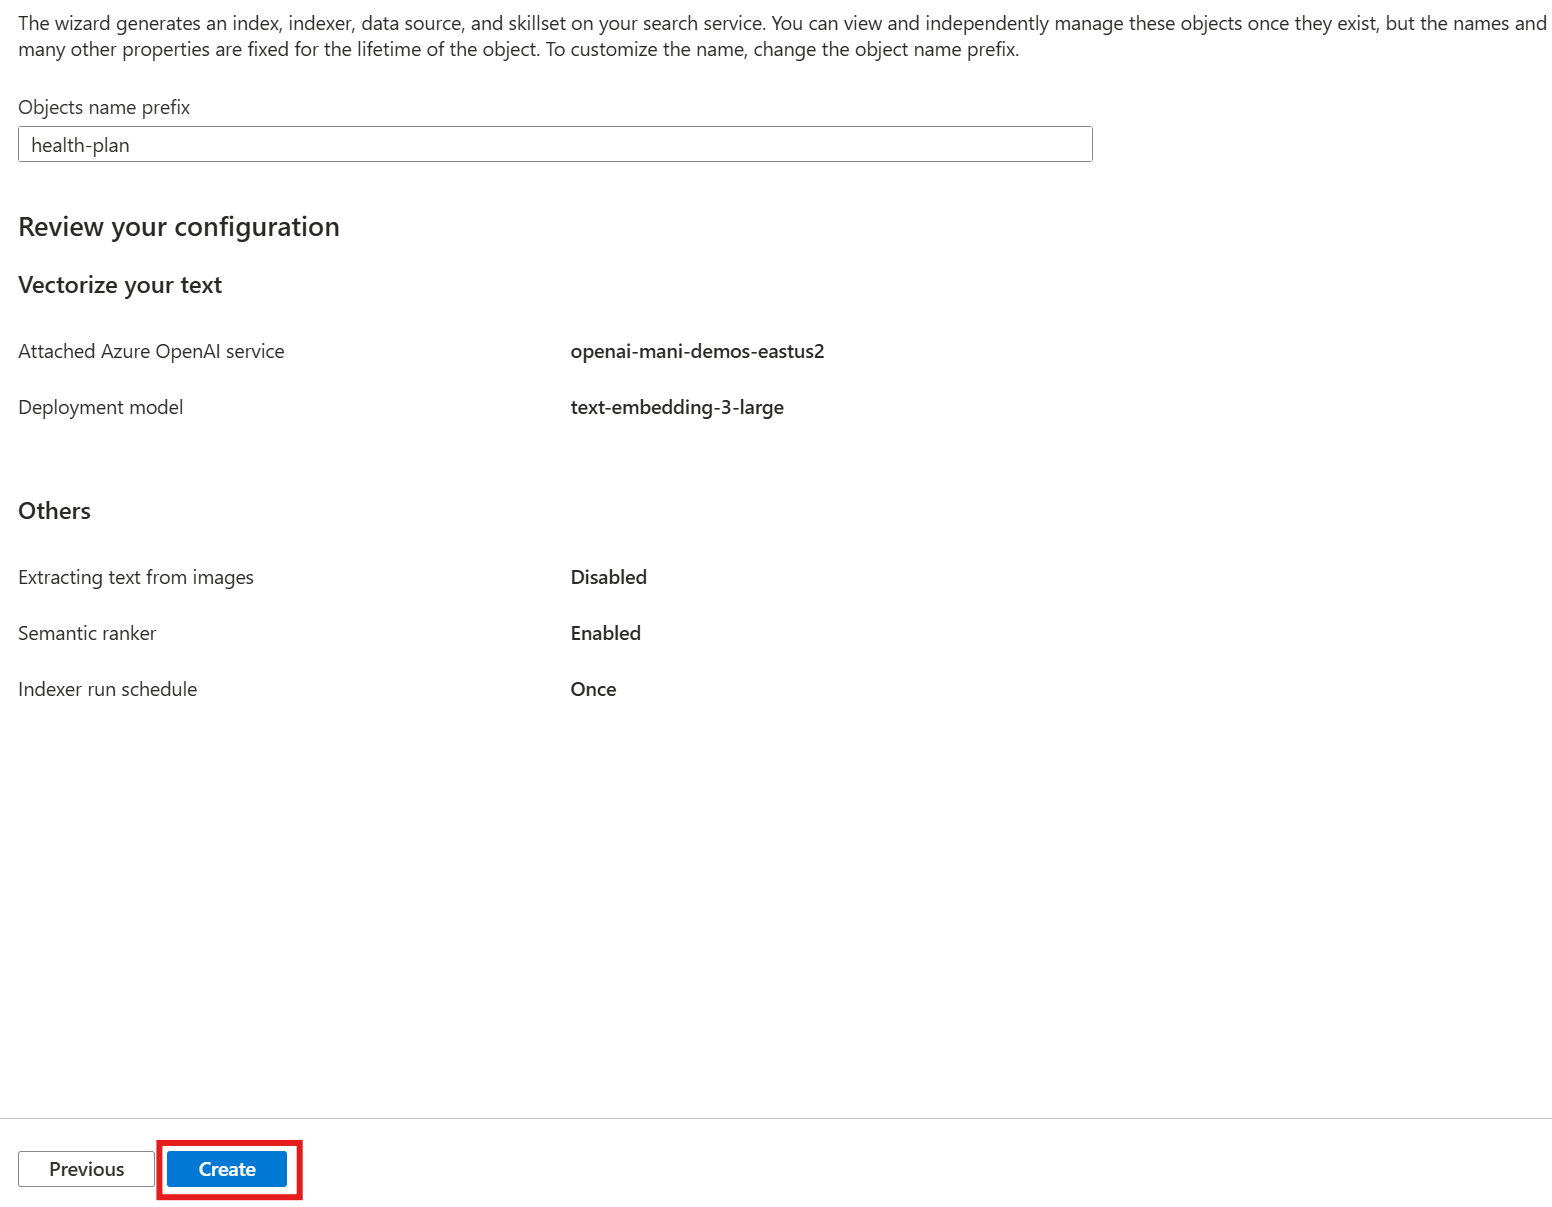



### Part 2: Create the Search Agent

Now that we've vectorized our health plan documents and created an index, we can create a Search Agent that will retreive information about our health plans from the index.


#### Step 1: Load the required libraries

In [7]:
import os
from semantic_kernel.functions import kernel_function
from dotenv import load_dotenv
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential
from azure.ai.projects.models import AzureAISearchTool

load_dotenv() # Loads the environment variables and credentials we need to setup the agent

True

#### Step 2: Connect to your Azure AI Foundry project

In [13]:
# Connecting to our Azure AI Foundry project, which will allow us to use the deployed gpt-4o model
project_client = AIProjectClient.from_connection_string(
    credential=DefaultAzureCredential(),
    conn_str=os.environ["PROJECT_CONNECTION_STRING"],
    )

#### Step 3: Connect to your Azure AI Search index

In [14]:
#conn_id = "/subscriptions/<your-subscription-id>/resourceGroups/<your-resource-group>/providers/Microsoft.MachineLearningServices/workspaces/<your-foundry-project>/connections/<your-search-service>"
conn_id = "/subscriptions/2d0ee675-17ff-4b13-a230-e84531ba4eab/resourceGroups/rg-mani-ai-demos/providers/Microsoft.MachineLearningServices/workspaces/ai-agent-sample/connections/aisearch-mani-demos-eastus2"
ai_search = AzureAISearchTool(index_connection_id=conn_id, index_name="health-plan")

#### Step 4: Define the search agent

In [18]:
search_agent = project_client.agents.create_agent(
    model="gpt-4o",
    name="search-agent",
    instructions="You are a helpful agent that is an expert at searching health plan documents.",
    tools=ai_search.definitions,
    tool_resources=ai_search.resources,
) 

#### Step 5: Chat with the search agent

Let's test our search agent by asking it to give us information about the Northwind Standard health plan.

In [ ]:
# The name of the health plan we want to search for
plan_name = 'Northwind Standard'

# Create a thread which is a conversation session between an agent and a user. 
thread = project_client.agents.create_thread()

# Create a message in the thread with the user asking for information about a specific health plan
message = project_client.agents.create_message(
    thread_id=thread.id,
    role="user",
    content=f"Tell me about the {plan_name} plan.", # The user's message
)
# Run the agent to process tne message in the thread
run = project_client.agents.create_and_process_run(thread_id=thread.id, assistant_id=search_agent.id)

# Check if the run was successful
if run.status == "failed":
    print(f"Run failed: {run.last_error}")

# Delete the agent when it's done running
project_client.agents.delete_agent(search_agent.id)

# Fetch all the messages from the thread
messages = project_client.agents.list_messages(thread_id=thread.id)

# Get the last message, which is the agent's resposne to the user's question
last_msg = messages.get_last_text_message_by_role("assistant")

# Display the agent's response
print('Agent:', last_msg.text.value)

Agent: The Northwind Standard plan is a comprehensive health plan that covers medical, vision, and dental services, along with preventive care and prescription drug coverage. It provides access to a variety of in-network providers, including primary care physicians, specialists, hospitals, and pharmacies. Some services under the plan may require pre-authorization and are subject to an annual deductible or coinsurance.

While the plan covers a broad range of services, it specifically excludes emergency services, mental health and substance abuse services, and out-of-network services【7:0†source】.
